Gradient Descent: Linear Regression Example
======

A simulated variation of https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

y = 10 * x + 30 + noise

Two model parameters:  
slope = 10  
bias = 30

Two random variables:  
x: np.random.uniform(low = 1.5, high = 5.0, size = None)  
noise: np.random.normal(loc = 0.0, scale = 5.0, size = None)

Recall that the mean squared error of the model will be the sum of reducible error and irreducible error:  
mean((actual - prediction)^2) + variance(noise)

So what is the minimum Mean Squared Error (MSE) for this problem?

---
Create the Data
-------

In [1]:
import numpy as np

count = 500

X = np.random.uniform(low = 1.5, high = 5.0, size = count).astype("float32")
Y1 = np.float32(10) * X + np.float32(30)
Y2 = np.random.normal(loc = 0.0, scale = 5.0, size = count)
Y = Y1 + Y2
X = X.reshape((X.shape[0], 1))

trnCount = int(0.8 * count)
valCount = int(0.1 * count)
tstCount = int(0.1 * count)

trnX = X[:trnCount]
valX = X[trnCount:(trnCount+valCount)]
tstX = X[(trnCount+valCount):]

trnY = Y[:trnCount]
valY = Y[trnCount:(trnCount+valCount)]
tstY = Y[(trnCount+valCount):]

print("trn shapes:", trnX.shape, trnY.shape, sep = "\t")
print("val shapes:", valX.shape, valY.shape, sep = "\t")
print("tst shapes:", tstX.shape, tstY.shape, sep = "\t")

trn shapes:	(400, 1)	(400,)
val shapes:	(50, 1)	(50,)
tst shapes:	(50, 1)	(50,)


---
Plot the Data
-------

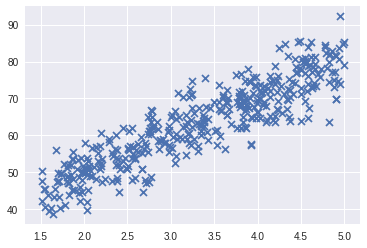

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn")
%matplotlib inline
plt.scatter(trnX[:,0], trnY, marker = 'x')
plt.show()

---
Create the Error Surface
-------

In [3]:
# we're integrating (1/(5 - 1.5))*(((10 * x + 30)-(slope * x + bias))^2) as x goes from 1.5 to 5
import numpy as np
X = np.linspace(8, 12, num = 41)
Y = np.linspace(28, 32, num = 41)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((Y.shape[0], X.shape[0]))
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        slope = X[i,j]
        bias = Y[i,j]
        # woo hoo: closed form solution for the definite integral
        Z[i,j] = (139 * (slope**2) - 5120 * slope + 12 * (bias**2) - 1500 * bias + 78 * slope * bias + 48100) / 12.0 + 25.0

---
Plot the Error Surface
-------

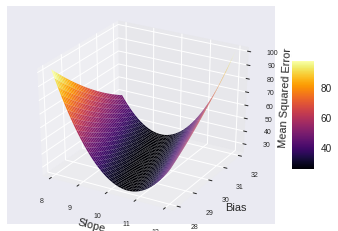

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection = "3d")
surf = ax.plot_surface(X, Y, Z, cmap = cm.inferno, linewidth = 0, antialiased = True)
plt.xticks(np.arange(8, 13))
plt.yticks(np.arange(28, 33))
plt.tick_params(axis = "both", which = "both", labelsize = 7)
ax.set_xlabel("Slope")
ax.set_ylabel("Bias")
ax.set_zlabel("Mean Squared Error")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

---
What is the lowest point on the error surface?
-------

In [5]:
print("params = (9.8, 29.8) in the lower, left-hand corner")
print("params = (10.2, 30.2) in the upper, right-hand corner")
print(np.rot90(Z)[18:23,18:23])

params = (9.8, 29.8) in the lower, left-hand corner
params = (10.2, 30.2) in the upper, right-hand corner
[[25.24333333 25.34333333 25.46333333 25.60333333 25.76333333]
 [25.02583333 25.06083333 25.11583333 25.19083333 25.28583333]
 [25.04       25.01       25.         25.01       25.04      ]
 [25.28583333 25.19083333 25.11583333 25.06083333 25.02583333]
 [25.76333333 25.60333333 25.46333333 25.34333333 25.24333333]]


---
Create the Model
-------

In [6]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.summary()
model.compile(loss = "mse", optimizer = optimizers.SGD(), metrics = [ "mse" ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


---
Prediction for a Single Example (forward propagation)
-------

In [7]:
old_weights = model.get_weights()
print(old_weights)
print(model.predict(trnX[:1]))
prediction = old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]
print(prediction)

[array([[1.2493912]], dtype=float32), array([0.], dtype=float32)]
1/1 [==============================] - 1s 741ms/step
[[5.1323214]]
5.1323214


---
Train on a Single Example (backward propagation)
-------

In [8]:
model.fit(trnX[:1], trnY[:1], epochs = 1, batch_size = 1)
new_weights = model.get_weights()
print(new_weights[0] - old_weights[0])
print(new_weights[1] - old_weights[1])

1/1 [==============================] - 0s 184ms/step - loss: 3474.1843 - mse: 3474.1843
[[4.8425245]]
[1.1788442]


In [9]:
# recall:
#     derivative((actual - activation)^2, activation) = 2 * (activation - actual)
#     derivative(activation, product) = 1    # linear activation: f(x) = x
#     derviative(product, weight) = input    # bias input = 1

lr = model.optimizer.lr.numpy()    # learning rate
np1 = np.float32(1)
np2 = np.float32(2)
w_update = - lr * (np2 * ((old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]) - trnY[0])) \
                * np1 \
                * trnX[0,0]
b_update = - lr * (np2 * ((old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]) - trnY[0])) \
                * np1 \
                * np1
print([ w_update, b_update ])

[4.84252417668944, 1.1788441872712354]


---
Prediction for a Batch of Examples (forward propagation)
-------

In [10]:
old_weights = model.get_weights()
indices = slice(1, 5)
batch_size = indices.stop - indices.start
print(model.predict(trnX[indices]))
predictions = np.dot(trnX[indices], old_weights[0]) + old_weights[1]
print(predictions)

1/1 [==============================] - 0s 11ms/step
[[18.006525]
 [24.896746]
 [26.140694]
 [14.564432]]
[[18.006525]
 [24.896746]
 [26.140694]
 [14.564432]]


---
Train a Batch of Examples (backward propagation)
-------

In [11]:
old_weights = model.get_weights()
model.fit(trnX[indices], trnY[indices], epochs = 1, batch_size = batch_size)
new_weights = model.get_weights()
print(new_weights[0] - old_weights[0])
print(new_weights[1] - old_weights[1])

1/1 [==============================] - 0s 73ms/step - loss: 1864.6826 - mse: 1864.6826
[[2.8044906]]
[0.8540125]


In [12]:
np2 = np.float32(2)
lr = model.optimizer.lr.numpy()    # learning rate

w_update = - lr * (np.dot(
                         np.transpose(trnX[indices]),
                         np.ones((batch_size, 1), dtype = 'float32') * np2 * (predictions - trnY[indices].reshape(batch_size, 1))
                        ) / batch_size)

b_update = - lr * (np.dot(
                         np.transpose(np.ones((batch_size, 1), dtype = 'float32')),
                         np.ones((batch_size, 1), dtype = 'float32') * np2 * (predictions - trnY[indices].reshape(batch_size, 1))
                        ) / batch_size)

print(w_update)
print(b_update)

[[2.80449032]]
[[0.8540126]]


---
Question: What's wrong with this picture?
-------

In [13]:
model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.1))
model.fit(trnX, trnY, validation_data = (valX, valY), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 1593612718571520.0000 - val_loss: 522794517464612864.0000
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 447678645475587584979632128.0000 - val_loss: 2466431361108301338107707392.0000
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: inf - val_loss: inf        
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: inf - val_loss: inf
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: inf - val_loss: inf
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/10
100/100 [==============================] - 0s 967us/step - loss: nan - val_loss: nan
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/10
100/100 [==========================

---
Question: Why doesn't this have the same problem?
-------

In [14]:
model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.001))
model.fit(trnX, trnY, validation_data = (valX, valY), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 1ms/step - loss: 791.9288 - val_loss: 104.7194
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 64.7765 - val_loss: 84.1854
Epoch 3/10
100/100 [==============================] - 0s 986us/step - loss: 82.2523 - val_loss: 81.2490
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 71.3950 - val_loss: 79.8187
Epoch 5/10
100/100 [==============================] - 0s 989us/step - loss: 64.9448 - val_loss: 82.2272
Epoch 6/10
100/100 [==============================] - 0s 971us/step - loss: 63.6152 - val_loss: 77.1118
Epoch 7/10
100/100 [==============================] - 0s 974us/step - loss: 78.4274 - val_loss: 74.7956
Epoch 8/10
100/100 [==============================] - 0s 998us/step - loss: 62.4822 - val_loss: 72.9366
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: 69.8963 - val_loss: 71.2827
Epoch 10/10
100/100 [==============================] - 0s 995us/step -

---
Normalizing the Data
-------

In [15]:
muX = np.mean(trnX[:,0])
sigmaX = np.std(trnX[:,0])

muY = np.mean(trnY)
sigmaY = np.std(trnY)

trnX_norm = (trnX - muX) / sigmaX
trnY_norm = (trnY - muY) / sigmaY
valX_norm = (valX - muX) / sigmaX
valY_norm = (valY - muY) / sigmaY

model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.001))

model.fit(trnX_norm, trnY_norm, validation_data = (valX_norm, valY_norm), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 1ms/step - loss: 3.6023 - val_loss: 3.4313
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 2.6268 - val_loss: 2.4099
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 2.2233 - val_loss: 1.5677
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 1.4845 - val_loss: 1.0326
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: 0.9979 - val_loss: 0.7061
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: 0.6543 - val_loss: 0.5164
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: 0.5698 - val_loss: 0.3765
Epoch 8/10
100/100 [==============================] - 0s 1ms/step - loss: 0.3789 - val_loss: 0.3080
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: 0.3039 - val_loss: 0.2549
Epoch 10/10
100/100 [==============================] - 0s 993us/step - loss: 0.3243 - val_loss: 0.21

---
Evaluating the Model
-------

In [16]:
tstX_norm = (tstX - muX) / sigmaX    # normalize the test data
predictions = model.predict(tstX_norm) * sigmaY + muY    # reverse the normalization
print(np.mean((tstY - predictions[:,0])**2))

2/2 [==============================] - 0s 2ms/step
44.21617840546721
